#### imports

In [ ]:
import generate_dataset as gd
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve

### Generate training and testing set

In [2]:
#training set
train_counts = {"high_intent": 250, "medium_intent": 250, "low_intent": 250, "no_intent": 250}
train_df = gd.generate_and_save_dataset(train_counts, save_csv=True, csv_path="train_balanced.csv")


#test set
n_test = 10000
test_counts = {
    "high_intent": int(n_test*0.01),
    "medium_intent": int(n_test*0.02),
    "low_intent": int(n_test*0.05),
    "no_intent": n_test - int(n_test*0.01) - int(n_test*0.02) - int(n_test*0.05)
}
test_df = gd.generate_and_save_dataset(test_counts, save_csv=True, csv_path="test_realistic.csv")

Saved dataset to train_balanced.csv
Saved dataset to test_realistic.csv


In [3]:
train_df = pd.read_csv("train_balanced.csv") 
test_df = pd.read_csv("test_realistic.csv")

print(train_df['intent'].value_counts())
print(test_df['intent'].value_counts(normalize=True))

intent
low_intent       250
medium_intent    250
no_intent        250
high_intent      250
Name: count, dtype: int64
intent
no_intent        0.92
low_intent       0.05
medium_intent    0.02
high_intent      0.01
Name: proportion, dtype: float64


### Training

#### all-MiniLM-L6-v2 encoding

In [4]:
model = SentenceTransformer("all-MiniLM-L6-v2")

X_train = model.encode(train_df['text'].tolist(), show_progress_bar=True, normalize_embeddings=True)
X_test = model.encode(test_df['text'].tolist(), show_progress_bar=True, normalize_embeddings=True)


Batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:09<00:00, 33.12it/s]


#### Label encoding

In [5]:
le = LabelEncoder()
y_train = le.fit_transform(train_df["intent"])
y_test = le.transform(test_df["intent"])
classes = le.classes_

#### Classifying with OneVsRestClassifier(LogisticRegression)

In [14]:
clf = OneVsRestClassifier(LogisticRegression(random_state=42))
clf.fit(X_train, y_train)

,estimator,LogisticRegre...ndom_state=42)
,n_jobs,None
,verbose,0
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42


### Evaluation

In [15]:
y_pred = clf.predict(X_test)
y_pred_probs = clf.predict_proba(X_test)

In [16]:
print(classification_report(y_test, y_pred, target_names=classes))
macro_auc = roc_auc_score(pd.get_dummies(y_test), y_pred_probs, average='macro')
print(f"Macro ROC-AUC: {macro_auc:.4f}")

               precision    recall  f1-score   support

  high_intent       1.00      1.00      1.00       100
   low_intent       1.00      1.00      1.00       500
medium_intent       0.73      0.99      0.84       200
    no_intent       1.00      0.99      1.00      9200

     accuracy                           0.99     10000
    macro avg       0.93      1.00      0.96     10000
 weighted avg       0.99      0.99      0.99     10000

Macro ROC-AUC: 0.9999


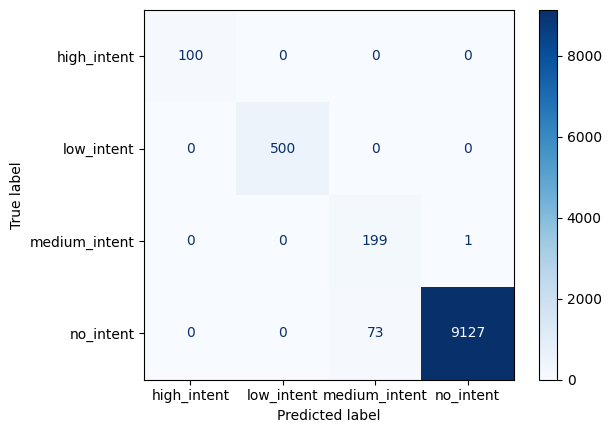

In [17]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

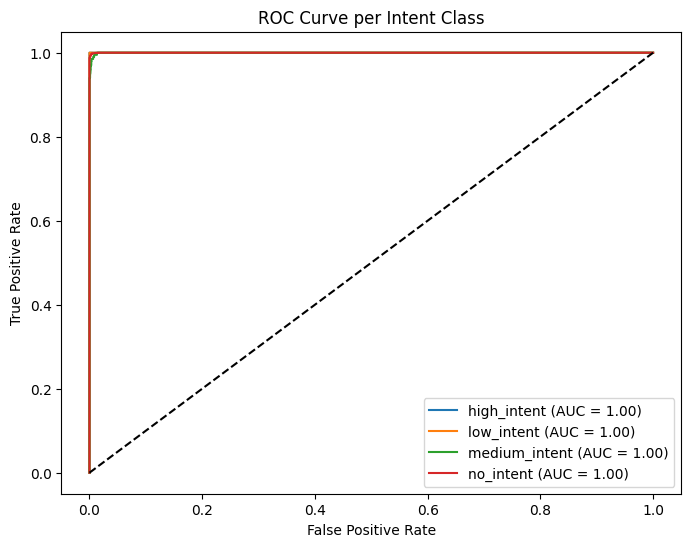

In [18]:
# ROC Curves
plt.figure(figsize=(8,6))
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_pred_probs[:, i])
    auc = roc_auc_score((y_test == i).astype(int), y_pred_probs[:, i])
    plt.plot(fpr, tpr, label=f"{cls} (AUC = {auc:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve per Intent Class")
plt.legend()
plt.show()
